# Анализ оттока клиентов с применением методов машинного обучения

Описание проекта:

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.


**Цель проекта:**

* Выбрать лучшую модель для прогнозирования факта оттока клиентов;
* Провести кластеризацию клиентов, изучить закономерности внутри классов и сформировать рекомендации по работе с клиентами. 


### Шаг 1. 
### Загрузка данных.

In [1]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [2]:
# Прочитаем файлы с данными

try:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')

except FileNotFoundError:
    
    gym_churn = pd.read_csv('gym_churn.csv')


In [3]:
gym_churn.columns = gym_churn.columns.str.lower()

In [4]:
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Шаг 2. 
### Исследовательский анализ данных (EDA)

Посмотрите на датасет: есть ли в нём отсутствующие значения (пропуски), изучите средние значения и стандартные отклонения (пригодится метод describe());

In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
gym_churn.duplicated().sum()

0

Пропусков не обнаружено, все данные приведены к нужным типам. Явных дубликатов так же не имеется.

In [7]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Изучив средние величины признаков можно сделать вывод:
* 51 % посетителей мужского пола (1);
* большинство посетителей проживают либо работают в непосредственной близости к фитнес-центру (около 84%);
* 48 % клиентов являются сотрудниками компании либо партнерами компании;
* около 30 % клиентов приходят по промоакции;
* средний возраст посетителя - 29 лет;
* 41% посетителей ходят на групповые занятия;
* разброс в значениях в данных с длительностью текущего действующего абонемента (месяц, 6 месяцев, год) - стандартвное отклонение равно 4,55. Основная часть пользователей имеет абонемент на 1 месяц. Только до 25% пользователей имеет абонементы на 6 месяцев.
* наибольший разброс данных наблюдается в данных с суммарной выручкой от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон. Стандартное отклонение равно 96,4. 75% клиентов тратят менее 210 рублей. Минимальные и максимальные суммы - 0,14 и 552 рубля соответственно.


Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby())

In [8]:
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Cредняя частота посещений в неделю за предыдущий месяц выше для тех, кто остался, почти в 2 раза.  Время с момента первого посещения для тех, кто остался выше почти в 5 раза. Срок до окончания действующего абонемента для них так же выше. Среди участников партнерских программ и пришедших по промокоду так же доля оставшихся с компанией выше. Чем ближе компания расположена к месту проживания или работе, тем больше вероятность, что клиент останется. 

Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

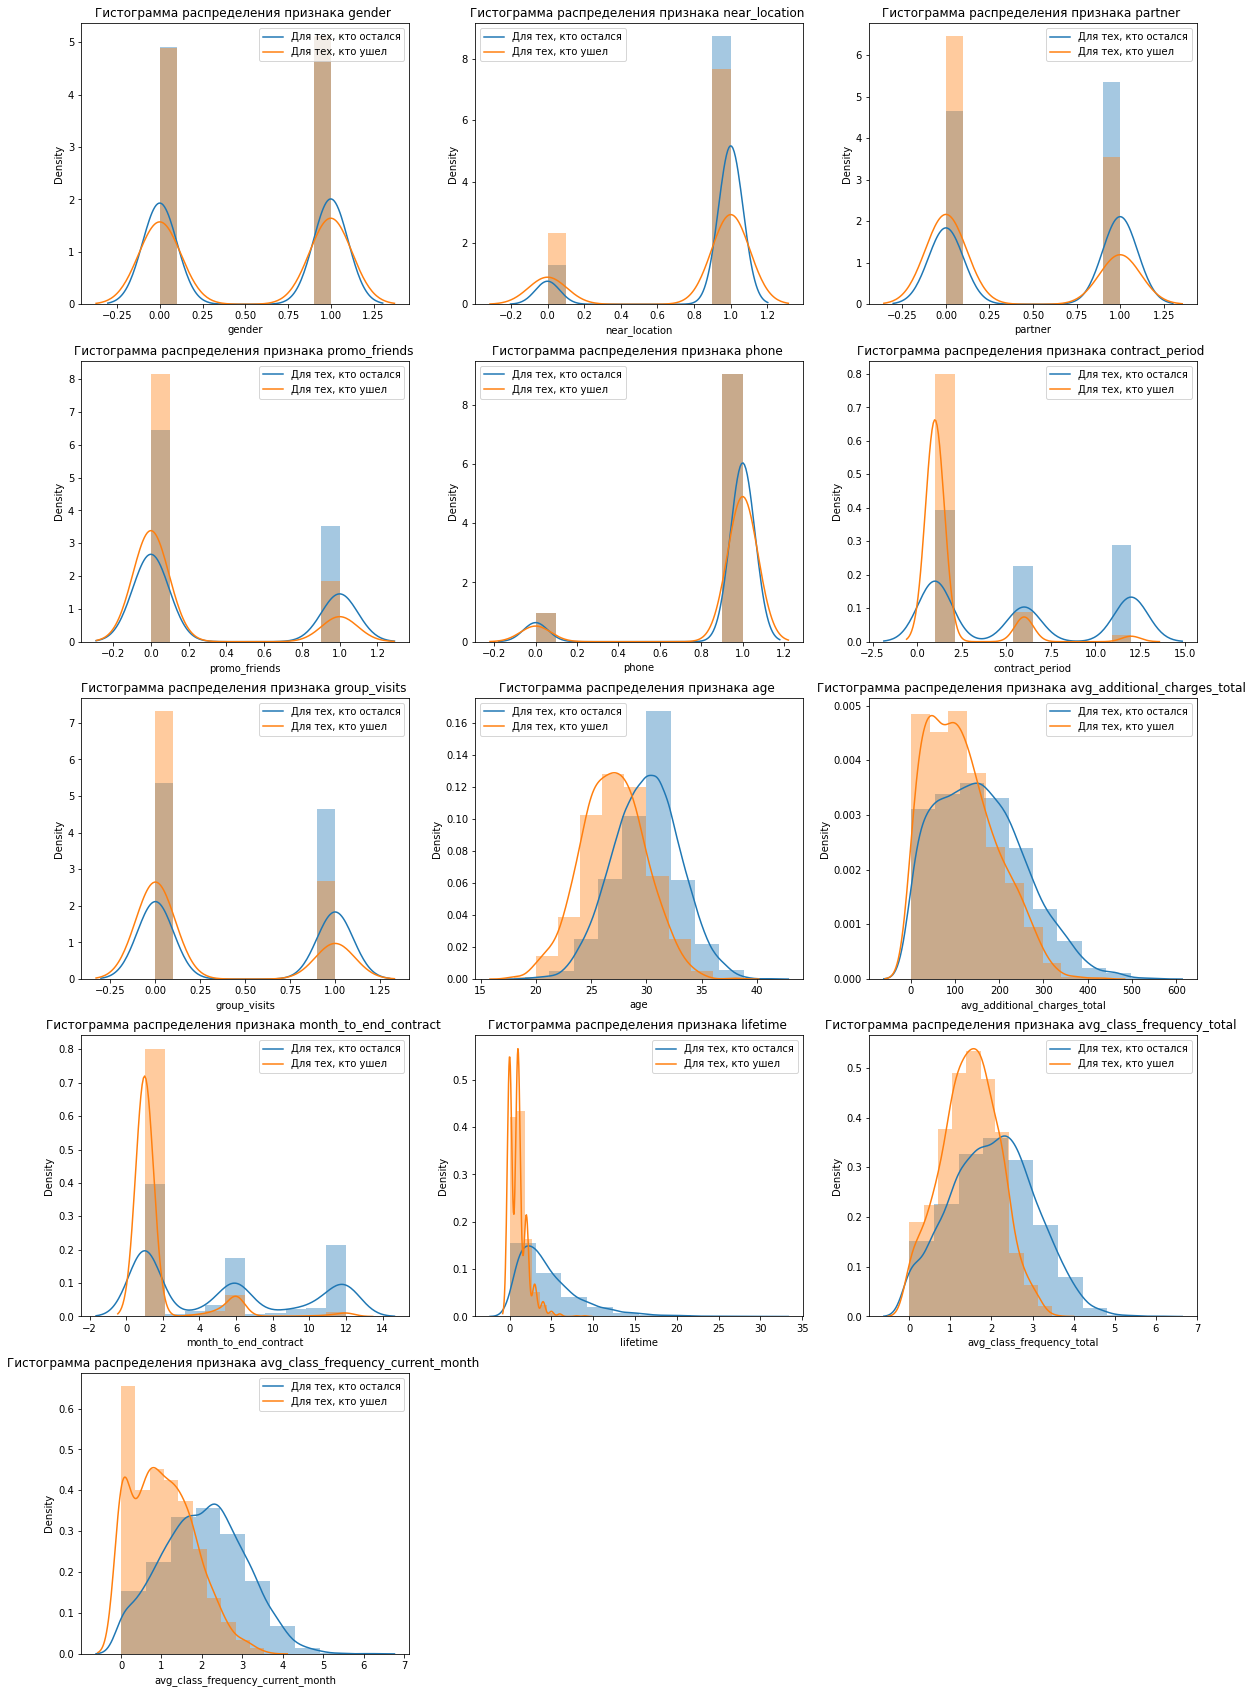

In [9]:
plt.figure(figsize=(20, 30))
def dist_gym_churn(df):
    subplt = 1
    for feature in df.drop(columns='churn').columns:
        ax = plt.subplot(5, 3, subplt)
        sns.distplot(df[feature], bins=10, ax=ax)
        subplt+=1
        plt.title('Гистограмма распределения признака {} '.format(feature))
        plt.legend (('Для тех, кто остался', 'Для тех, кто ушел'))
dist_gym_churn(gym_churn.query('churn == 0'))
dist_gym_churn(gym_churn.query('churn == 1'))

plt.show()

Клиенты с абонементом в месяц уходят чаще - что логично. Лайфтайм соответственно ниже, а так же средняя частота посещений в неделю. Уходящая аудитория имеет более молодой возраст. Ушедшие меньше посещают групповые занятия. 

Постройте матрицу корреляций и отобразите её.

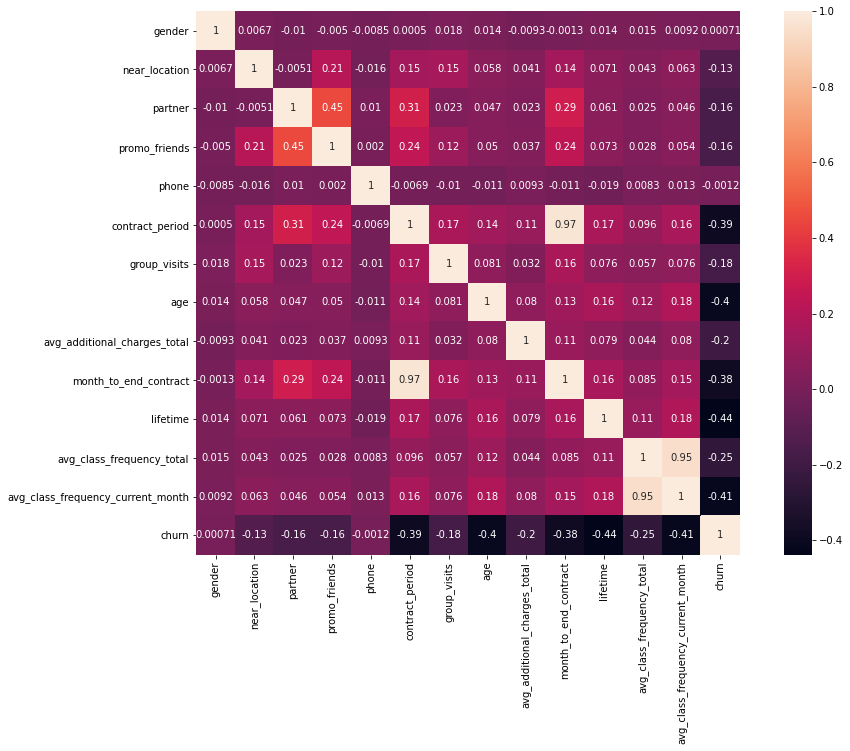

In [10]:
#построим и отрисуем матрицу корреляций
cm = gym_churn.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(16, 10))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True) #ваш код здесь
ax.set_ylim(
    14, 0
)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()


На тепловой карте корреляций мы можем увидеть сильную взаимоствязь между признаками `avg_class_frequency_total` и `avg_class_frequency_current_month` коэффициент корреляции в этом случае составил 0.95, что кажется логичным.

Так же наблюдается сильная взаимосвязь показателей `month_to_end_contract` и `contract_period` (коэффициент корреляции 0.97), что свидетельствует о том, что в выборку вошли клиенты недавно оформившие обонементы в спортзал.

Нужно отметить обратную зависимость оттока клиентов. Чем моложе клиенты, тем чаще они уходят, чем выше лайфтайм, тем реже уходят клиенты.

### Шаг 3. 
### Постройте модель прогнозирования оттока клиентов

Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

* Разбейте данные на обучающую и валидационную выборку функцией train_test_split()

In [11]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(['churn', 'month_to_end_contract', 'avg_class_frequency_current_month'], axis=1) #ваш код здесь
y = gym_churn['churn'] #ваш код здесь 

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #ваш код здесь

# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Построим гистограммы целевой переменной на обучающей и валидационной выборках, чтобы сравнить распределения. 

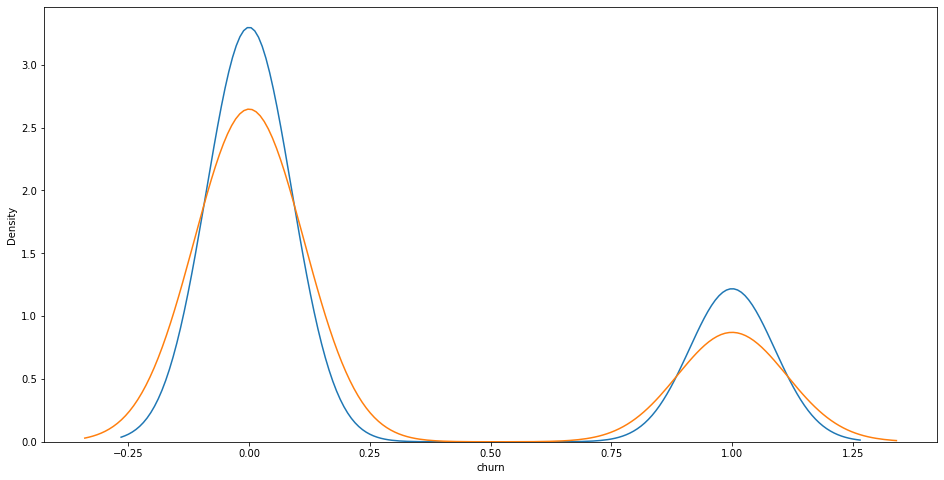

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
# гистограмма целевой переменной на train
sns.kdeplot(y_train) # напишите ваш код здесь
# гистограмма целевой переменной на test
sns.kdeplot(y_test) # напишите ваш код здесь
plt.show()

Судя по целевой переменной, распределения на test и train похожи. 

Стоит отметить что мы ислючили сильно коррелируемые с другими признаки, чтобы избежать искажения результатов.

* Обучите модель на train-выборке двумя способами:
   1. логистической регрессией - sklearn.linear_model.LogisticRegression(),
   2. случайным лесом - sklearn.ensemble.RandomForestClassifier().


In [13]:
# задайте алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)
# обучите модель
model.fit(X_train_st, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

print(predictions[0:10])
probabilities.round(4)[0:10]

[0 1 1 1 0 0 0 0 1 0]


array([0.0033, 0.957 , 0.5413, 0.8104, 0.0641, 0.0087, 0.0414, 0.0017,
       0.8513, 0.0083])

In [14]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100)

# обучите модель
rf_model.fit(X_train_st, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
y_pred = rf_model.predict(X_test_st) 
y_prob = rf_model.predict_proba(X_test_st)[:, 1]

print(y_pred[0:10])
y_prob.round(4)[0:10]

[0 1 0 1 0 0 0 0 1 0]


array([0.  , 0.95, 0.18, 0.93, 0.2 , 0.01, 0.06, 0.01, 0.91, 0.06])

Мы вывели первые 10 значений предсказаний и вероятности наступления факта оттока для клиентов. Мы уже можем наблюдать различия в предсказаниях при применении двух разных моделей прогнозирования оотка клиентов. Теперь нужно разобраться, результатам работы какой модели мы можем доверять больше. Для этого изучим следующие метрики.

* Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [15]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


In [16]:
print_all_metrics(
    y_test,
    predictions,
    probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test,
    y_pred,
    y_prob,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
	F1: 0.80
	ROC_AUC: 0.95
Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.79
	Recall: 0.75
	F1: 0.77
	ROC_AUC: 0.94


Мы можем увидеть, что с применением модели логистической регрессии в целом метрики превосходят, метрик расчитанных в случае применения модели случайного леса.

Так как мы имеем несбалансированные выборки по признаку `churn`, результат predict_proba() нельзя интерпретировать как вероятность класса. Поэтому критически важно настроить нужный порог для отнесения к классу (threshold).

Если с учётом признаков, можно сказать, что вероятность отнесения к классу "1" больше 0.5 — значит всё-таки уверенность больше в классе "1", чем "0", и наоборот. Исходя из этого определяем порог: к "1" относим все объекты, для которых predict_proba() для класса "1" выдала значение больше, чем 0.5, или наоборот соответственно.

In [17]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:\n', gym_churn['churn'].value_counts())


Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


In [18]:
# задайте порог
threshold = 0.36

# на основании вероятностей и соотношения классов рассчитайте predict
custom_predictions = [0 if i < threshold else 1 for i in probabilities]
custom_pred = [0 if i < threshold else 1 for i in y_prob]
print_all_metrics(
    y_test,
    custom_predictions,
    probabilities,
    title='Метрики для модели логистической регрессии c порогом 0.36:',
)
print_all_metrics(
    y_test,
    custom_pred,
    y_prob,
    title='Метрики для модели случайного леса c порогом 0.36:',
)

Метрики для модели логистической регрессии c порогом 0.36:
	Accuracy: 0.88
	Precision: 0.71
	Recall: 0.86
	F1: 0.78
	ROC_AUC: 0.95
Метрики для модели случайного леса c порогом 0.36:
	Accuracy: 0.88
	Precision: 0.72
	Recall: 0.84
	F1: 0.77
	ROC_AUC: 0.94


При использовании кастомного трешхолда приоритетная метрика `Recall` выросла, а вот на метрики `Accuracy` и `Precision` это сказалось негативно. И метрики данных моделей выровнялись, но метрика `Recall` для модели логистической регрессии так же лидирует, но незначительно

### Шаг 4. 
### Сделайте кластеризацию клиентов

Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):

* **Стандартизируйте данные.**

In [19]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

* **Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.**

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [21]:
linked = linkage(X_sc, method = 'ward')

В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму:

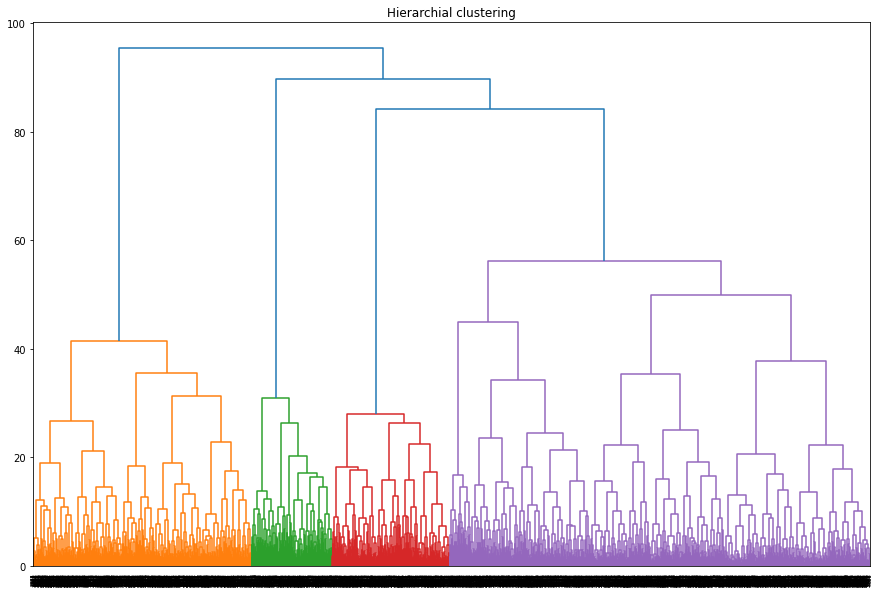

In [22]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

* **Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).**

Принцип работы пошагового алгоритма K-means:
1. Есть K кластеров. Алгоритм пошагово подбирает их центры и относит объекты к тому кластеру, чей центр ближе.
2. Центры корректируются (меняют своё положение) до тех пор, пока это позволяет минимизировать среднее расстояние от объектов каждого кластера до его центра.
3. Когда расстояние от объектов до центра перестаёт снижаться или сокращается несущественно, алгоритм останавливается и фиксирует разбиение, считая его оптимальным.


In [23]:
from sklearn.cluster import KMeans

In [24]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state 
                                          # для воспроизводимости результата
    
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

В переменной labels сохраняются индексы предложенных алгоритмом групп. Алгоритм случайно назначает номер определённой группе, поэтому искать в этой цифре какой-то смысл не нужно: группа с индексом 2 не «ближе» к группе с индексом 3, чем группа 1. Важно, что объекты, которым модель присвоила один и тот же индекс, относятся к одному кластеру.

* **Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?**

In [25]:
gym_churn['cluster'] = labels # сохраняем метки кластера в поле нашего датасета

In [26]:
# выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,2.853832,3.060606,1.770413,1.606619,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,6.988571,4.380952,1.978963,1.933736,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,2.650177,3.343640,1.800647,1.645965,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,4.165327,3.761194,1.941342,1.845911,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


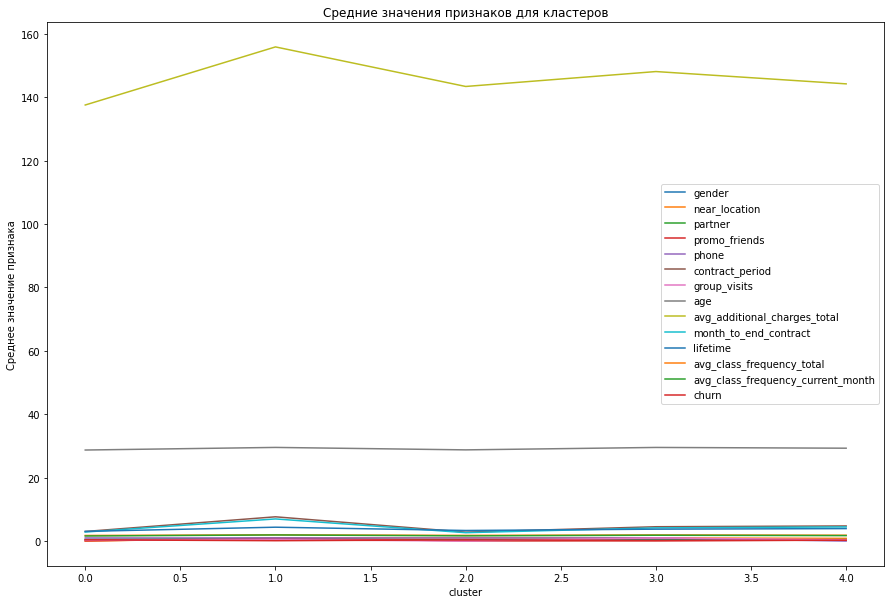

In [27]:
gym_churn.groupby('cluster').mean().plot(figsize=(15, 10))
plt.title('Средние значения признаков для кластеров')
plt.ylabel("Среднее значение признака")
plt.show()

По графику изменения средних значений признаков можно отметить что в кластере под номером 1 они самые высокие значения.

* **Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?**

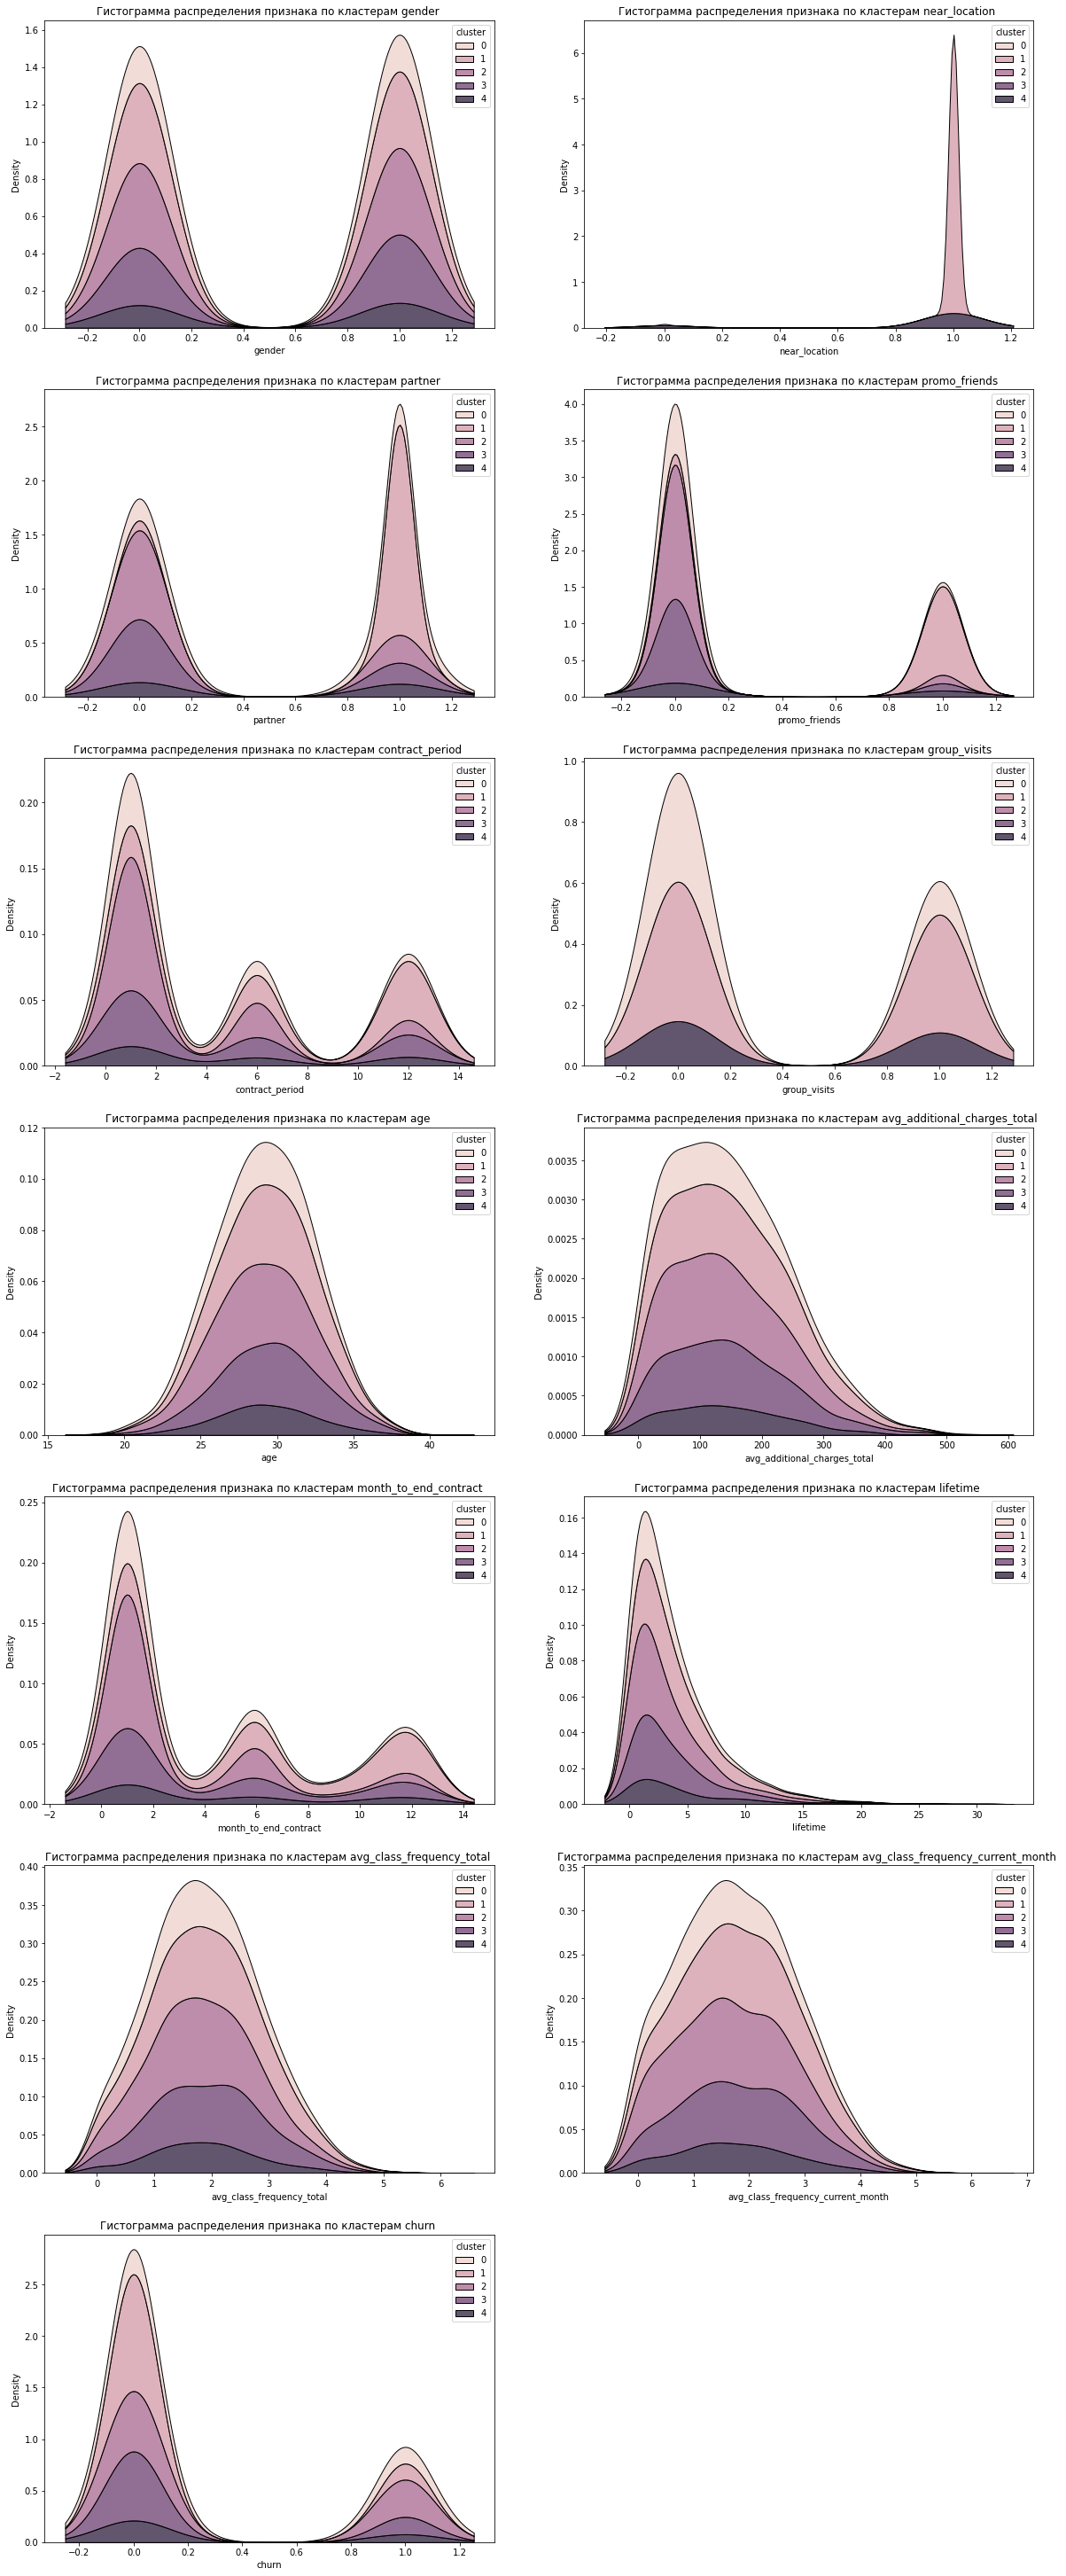

In [28]:
# построим распределения признаков в разрезе кластеров
plt.figure(figsize=(20, 60))
subplt=1
for column in gym_churn.drop(columns=['cluster','phone']).columns:
    ax = plt.subplot(8, 2, subplt)
    sns.kdeplot(x=column,
                hue='cluster',
                multiple='stack',
                data=gym_churn, ax=ax)
    plt.title('Гистограмма распределения признака по кластерам {} '.format(column))
    subplt+=1
    
    
plt.show()

По данным диаграммам можно сделать вывод, что практически для всех признаков преобладает число клиентов относящихся к кластеру под номером `0`. Чего не скажешь о признаке `near_location`, клиенты проживающие рядом с залом составляют преимущественно кластер под номером `1`. Сотрудники организаций-партнеров и клиенты, приведенные по промокоду так же преимущественно входят в группу под номером `0` и `1`. Клиенты `2` и `3` классов не посещают групповые занятия. Факт оттока распределился так же соответственно размерам групп клиентов по классам. Больше всего ушло клиентов, входящих в группу `0`, затем `1`, `2`, `3` и `4`. Но невооруженным глазом видно что, доля ушедших выcока в группе `2`.

In [29]:
import itertools

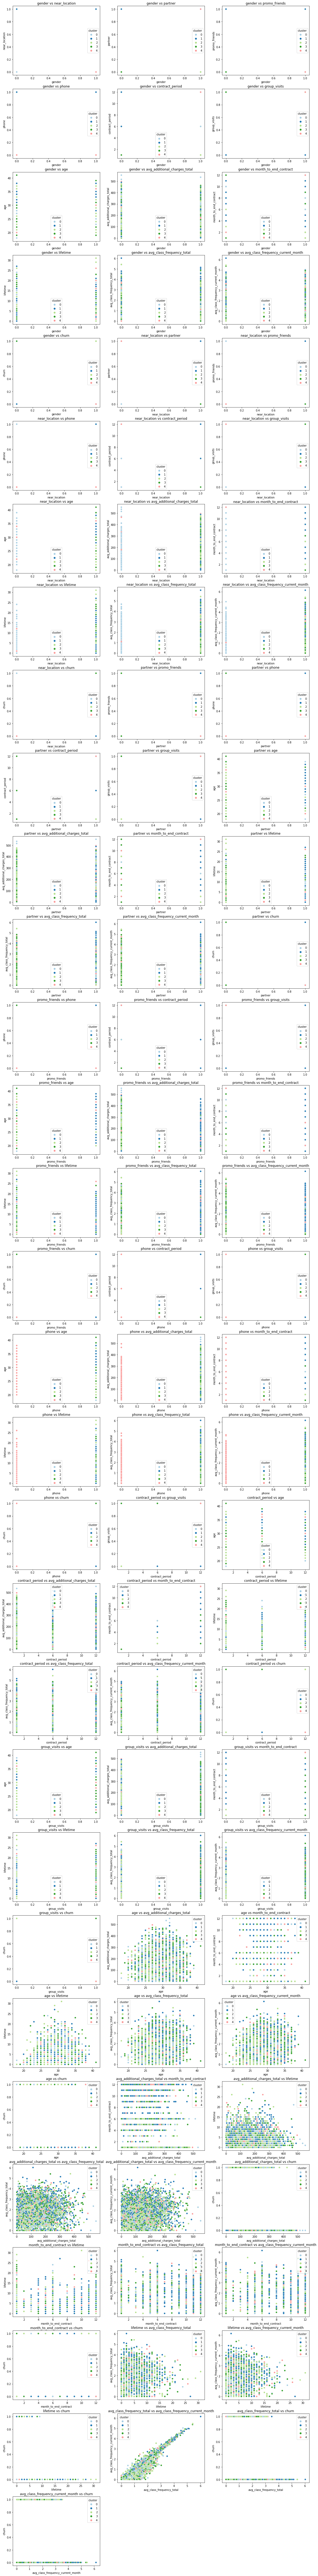

In [30]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name, subplt):
    #plt.figure(figsize=(10, 10))
    
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired', ax=ax
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    #plt.show()

    
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам


col_pairs = list(itertools.combinations(gym_churn.drop('cluster', axis=1).columns, 2))

plt.figure(figsize=(20, 200))
subplt = 1
for pair in col_pairs:
    ax = plt.subplot(35, 3, subplt)
    show_clusters_on_plot(gym_churn, pair[0], pair[1], 'cluster', subplt)
    subplt += 1
plt.show()

По графикам попарного сочетания признаков в получившихся кластерах, можно увидеть ссильную взаимосвязь средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц, которую мы выявили ранее, четче она прослеживается в группе `1`. Кластер `4` не содержит номера телефонов. Партнеры и друзья преимущественно относятся к кластерам `0` и `1`. Лайфтайм для группы `1` выше, чем для других кластеров. Клиенты, вошедшие в кластер `0` не живут и не работают в непосредственной близости от зала.

* **Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?**

In [31]:
# выводим статистику по долям оттока в разрезе наших кластеров
gym_churn.groupby('cluster').agg({'churn':'mean'}).reset_index().sort_values(by='churn', ascending=False)

,cluster,churn
0,0,0.399287
2,2,0.381625
4,4,0.266839
3,3,0.200918
1,1,0.120952


Кластеры `0` и `2` склонны к оттоку, число ушедших в этих группах доходит до 40 %. Тогда как наиболее надежной является кластер `1`, где отток составляет всего 12 %. Можно предположить, что близость к дому является решающим признаком, влияющим на отток клиентов. Так же важны промоакции, и программы для партнеров.

### Шаг 5. 
### Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

* Построив модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце и применив для этого методы логистической регрессии и случайного леса, мы сделали вывод, что наиболее привлекательным методом является метод логистической регрессии. Данный вывод мы сделали на основе расчитанных метрик, приоритетной из которых является метрика `Recall`.
* Мы разбили объекты на 5 кластеров, и изучив закономерности внутри каждого кластера мы сделали вывод:

     1. Самые надежные клиенты живут и работают в непосредственной близости от фитнес-центров, поэтому при запуске рекламных кампаний наибольшее внимание стоит уделить локации аудитории, для которой проводится рекламная кампания;
     2. Сотрудники организаций-партнеров так же остаются с компанией надолго, поэтому стоит расширить круг партнеров, при этом соблюдая принцип выбора компании, по локации в непосредственной близости к филиалам фитнес-центров;
     3. Так же следует поработать активнее с промо-акциями "Приведи друга", ведь среди клиентов пришедших таким путем тоже много надежных.
     
Большая часть клиентов из кластеров 0 и 2 имеют абонемент 1 месяц, тогда как обьекты кластера 1 с наиболее надежными клиентами, имеют абонемент в 12 месяцев, можно предположить, что на отток влияет срок заключения договора. Так же клиенты из 0 и 2 кластера в большинстве своем не ходят на групповый занятия, что тоже может сказаться на оттоке.
   